In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("everydaycodings/global-news-dataset")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/global-news-dataset...
Path to dataset files: /kaggle/input/global-news-dataset


In [96]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import spacy
from heapq import nlargest
from transformers import BartForConditionalGeneration, BartTokenizer
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv('/kaggle/input/global-news-dataset/data.csv')
df.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
0,89541,NaN,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,https://www.ibtimes.com/un-chief-urges-world-s...,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35.000000,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...
1,89542,NaN,Prtimes.jp,NaN,RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。,[株式会社Ainer]\nRANDEBOO（ランデブー）では2023年7月18日(火)より公...,https://prtimes.jp/main/html/rd/p/000000147.00...,https://prtimes.jp/i/32220/147/ogp/d32220-147-...,2023-10-06 04:40:02.000000,"RANDEBOO2023718()WEB2023 Autumn Winter \n""Nepa...",Nepal,NaN
2,89543,NaN,VOA News,webdesk@voanews.com (Agence France-Presse),UN Chief Urges World to 'Stop the Madness' of ...,UN Secretary-General Antonio Guterres urged th...,https://www.voanews.com/a/un-chief-urges-world...,https://gdb.voanews.com/01000000-0a00-0242-60f...,2023-10-30 10:53:30.000000,"Kathmandu, Nepal UN Secretary-General Antonio...",Nepal,NaN
3,89545,NaN,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,https://indianexpress.com/article/opinion/edit...,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24.000000,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...
4,89547,NaN,The Times of Israel,Jacob Magid,"200 foreigners, dual nationals cut down in Ham...","France lost 35 citizens, Thailand 33, US 31, U...",https://www.timesofisrael.com/200-foreigners-d...,https://static.timesofisrael.com/www/uploads/2...,2023-10-27 01:08:34.000000,"Scores of foreign citizens were killed, taken ...",Nepal,NaN


In [4]:
df.shape

(105375, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105375 entries, 0 to 105374
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   article_id    105375 non-null  int64 
 1   source_id     24495 non-null   object
 2   source_name   105375 non-null  object
 3   author        97156 non-null   object
 4   title         105335 non-null  object
 5   description   104992 non-null  object
 6   url           105375 non-null  object
 7   url_to_image  99751 non-null   object
 8   published_at  105375 non-null  object
 9   content       105375 non-null  object
 10  category      105333 non-null  object
 11  full_content  58432 non-null   object
dtypes: int64(1), object(11)
memory usage: 9.6+ MB


In [6]:
df.apply(pd.isnull).sum()

article_id          0
source_id       80880
source_name         0
author           8219
title              40
description       383
url                 0
url_to_image     5624
published_at        0
content             0
category           42
full_content    46943
dtype: int64

In [7]:
df['category'].value_counts()

category
Stock          3999
Health         2594
Finance        2402
Technology     2371
Real estate    2352
               ... 
Eritrea          14
Martinique       13
Cabo Verde       11
Réunion           9
Guadeloupe        4
Name: count, Length: 257, dtype: int64

In [8]:
data = df[['full_content', 'category']]

In [9]:
data.head()

,full_content,category
0,UN Secretary-General Antonio Guterres urged th...,Nepal
1,NaN,Nepal
2,NaN,Nepal
3,At least 14 persons lost their lives and more ...,Nepal
4,NaN,Nepal


In [10]:
data.isnull().sum()

full_content    46943
category           42
dtype: int64

In [11]:
data.dropna(subset = ['full_content', 'category'], inplace = True)

<ipython-input-11-b64810699d6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset = ['full_content', 'category'], inplace = True)


In [12]:
data.head()

,full_content,category
0,UN Secretary-General Antonio Guterres urged th...,Nepal
3,At least 14 persons lost their lives and more ...,Nepal
6,"India, the first non-Arab country to recognise...",Nepal
7,Written by Alex Travelli and Hari Kumar No nat...,Nepal
12,NEW DELHI: India preferred Bangladesh over Nep...,Nepal


In [13]:
data.shape

(58411, 2)

In [14]:
data.isnull().sum()

full_content    0
category        0
dtype: int64

In [15]:
data['full_content'][0]

'UN Secretary-General Antonio Guterres urged the world Monday to "stop the madness" of climate change as he visited Himalayan regions struggling from rapidly melting glaciers to witness the devastating impact of the phenomenon. "The rooftops of the world are caving in," Guterres said on a visit to the Everest region in mountainous Nepal, adding that the country had lost nearly a third of its ice in just over three decades. "Glaciers are icy reservoirs -- the ones here in the Himalayas supply fresh water to well over a billion people," he said. "When they shrink, so do river flows." Nepal\'s glaciers melted 65 percent faster in the last decade than in the previous one, said Guterres, who is on a four-day visit to Nepal. Glaciers in the wider Himalayan and Hindu Kush ranges are a crucial water source for around 240 million people in the mountainous regions, as well as for another 1.65 billion people in the South Asian and Southeast Asian river valleys below. The glaciers feed 10 of the w

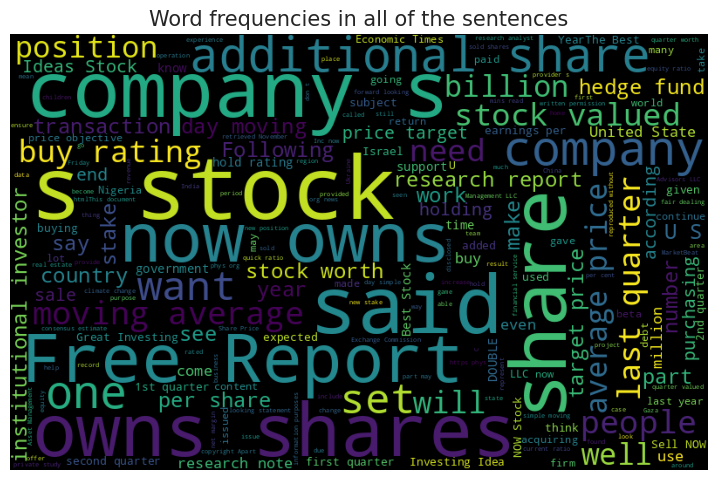

In [16]:
plt.figure(figsize = (9, 7))
all_sen = ' '.join([sentence for sentence in data['full_content']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sen)
plt.imshow(word_cloud)
plt.title('Word frequencies in all of the sentences', fontsize = 15)
plt.axis('off')
plt.show()

In [17]:
sw = stopwords.words('english')

In [19]:
def text_cleaning(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    return words

In [30]:
nlp = spacy.load('en_core_web_sm')

In [46]:
def extractive_summarization(text, num_sent):
    words = text_cleaning(text)
    word_freq = Counter(words)
    max_freq = max(word_freq.values())
    for word, freq in word_freq.items():
        word_freq[word] = freq / max_freq
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    sent_freq = dict()
    for sentence in sentences:
        for word in sentence.split():
            if word in word_freq.keys():
                if sentence not in sent_freq.keys():
                    sent_freq[sentence] = word_freq[word]
                else:
                    sent_freq[sentence] += word_freq[word]
    n = nlargest(num_sent, sent_freq, key = sent_freq.get)
    final_sents = []
    for i in sentences:
        for j in n:
            if i == j:
                final_sents.append(i)
    return ' '.join(final_sents)

In [50]:
data.head()

,full_content,category
0,UN Secretary-General Antonio Guterres urged th...,Nepal
3,At least 14 persons lost their lives and more ...,Nepal
6,"India, the first non-Arab country to recognise...",Nepal
7,Written by Alex Travelli and Hari Kumar No nat...,Nepal
12,NEW DELHI: India preferred Bangladesh over Nep...,Nepal


In [51]:
data.reset_index(drop = True, inplace = True)

In [52]:
data.head()

,full_content,category
0,UN Secretary-General Antonio Guterres urged th...,Nepal
1,At least 14 persons lost their lives and more ...,Nepal
2,"India, the first non-Arab country to recognise...",Nepal
3,Written by Alex Travelli and Hari Kumar No nat...,Nepal
4,NEW DELHI: India preferred Bangladesh over Nep...,Nepal


In [57]:
min_length = min([len(i) for i in data['full_content']])
min_length

1

In [59]:
[i for i in data['full_content'] if len(i) == 0]

[]

In [61]:
data[data['full_content'] == ' ']

,full_content,category
950,,Real estate
52633,,Israel
53592,,Canada
54668,,Israel


In [62]:
data.shape

(58411, 2)

In [63]:
data = data[data['full_content'] != ' ']

In [64]:
data.shape

(58407, 2)

In [65]:
data.reset_index(drop = True, inplace = True)

In [73]:
data['category'].value_counts()

category
Stock          3680
Canada         2199
Health         2074
Real estate    1991
Technology     1961
               ... 
Honduras          3
Andorra           3
Cabo Verde        3
Martinique        2
Réunion           2
Name: count, Length: 256, dtype: int64

In [79]:
data_health = data[data['category'] == 'Health'].sample(100)
data_real = data[data['category'] == 'Real estate'].sample(100)
data_tech = data[data['category'] == 'Technology'].sample(100)

In [80]:
data_new = pd.concat([data_health, data_real, data_tech])

In [81]:
data_new.reset_index(drop = True, inplace = True)

In [82]:
data_new.shape

(300, 3)

In [83]:
data_new['extractive_summ'] = data_new['full_content'].apply(lambda x: extractive_summarization(x, 3))

In [84]:
data_new

,full_content,category,extractive_summ
0,Workers are taking their problems with their b...,Health,Thirty-one percent of those surveyed said they...
1,GENEVA --International aid groups say they are...,Health,“The entire humanitarian sector is ready to sc...
2,"13 November 2023 - More patients, including p...",Health,"13 November 2023 - More patients, including p..."
3,Wildland firefighters on the Spring Creek Fire...,Health,A long running effort to permanently boost pay...
4,"LONDON --Earlier this year, the doctor who lea...",Health,"LONDON --Earlier this year, the doctor who lea..."
...,...,...,...
295,North Korea has issued formal notice of a sate...,Technology,The launch would be the third attempt by North...
296,Shares of Singularity Future Technology Ltd. (...,Technology,"Jane Street Group LLC now owns 28,473 shares o..."
297,BlackRock Smaller Companies Trust plc (LON:BRS...,Technology,"The company has a current ratio of 3.57, a qui..."
298,Brown Brothers Harriman & Co. lifted its posit...,Technology,"Sawyer & Company Inc now owns 12,042 shares of..."


In [85]:
data_new['full_content'][0]

'Workers are taking their problems with their bosses out of the office and into therapy. Twenty-nine percent — or nearly one third — of the 1,233 American workers surveyed byThe Harris Pollin a recent study reported going to therapy to cope with their toxic bosses. Researchersdefined a "toxic boss"as one who exhibits behaviors like micromanagement, credit-stealing, setting unreasonable expectations, unprofessionalism, and unapproachability. Thirty-one percent of those surveyed said they currently have aboss who exhibits toxic behavior, while 71% said they have had at least one toxic boss throughout their career. "It\'s nothing short of astonishing how the presence of toxicity not only persists but actively flourishes within certain workplace environments," Libby Rodney, the chief strategy officer at The Harris Poll, told Insider over email. This toxicity can lead to to mental health problems, which is likely why so many workers seek therapy: 74% of workers who said they have a toxic bo

In [87]:
data_new['extractive_summ'][0]

'Thirty-one percent of those surveyed said they currently have aboss who exhibits toxic behavior, while 71% said they have had at least one toxic boss throughout their career. This toxicity can lead to to mental health problems, which is likely why so many workers seek therapy: 74% of workers who said they have a toxic boss reported feeling anxiety over the weekend when thinking about returning to work on Monday — sometimes known asthe "Sunday scaries"— while 53% reported having nightmares about their bosses. Despite the toll toxic bosses can take on workers\' lives, the majority of workers with toxic bosses say they tolerate them for financial reasons, including salary, benefits, and the fear of leaving in an uncertain economic climate.'

In [88]:
data_new['full_content'][1]

'GENEVA --International aid groups say they are ready to deliver thousands of truckloads of food, water and other supplies to besieged Gaza if a temporary cease-fire in the Israel-Hamas war takes hold. Some hailed an important first step, but many said Wednesday that a four-day truce isn\'t enough to meet overwhelming needs after seven weeks of fighting have displaced hundreds of thousands of Palestinians now living in miserable conditions. Key details of the accord announced Wednesday remain unclear, including the mechanics of getting more aid to desperate civilians and escorting the first group of Israeli hostages out of Gaza where they have been held since Hamas’ Oct. 7 rampage in Israel. The cease-fire efforts hit a hurdle Wednesday when Israel’s national security adviser Tzachi Hanegbi said in a late-night announcement that the deal would not take effect before Friday, a day later than originally expected. Aid groups say a key ambition is to get help to northern Gaza, which has be

In [89]:
data_new['extractive_summ'][1]

"“The entire humanitarian sector is ready to scale up once everything is set,” said Tommaso Della Longa, a spokesman for the International Federation of Red Cross and Red Crescent Societies, an umbrella organization that amounts to the world's largest humanitarian aid group. The international community and aid groups have been trying to find ways to get aid into Gaza since Israel retaliated for Hamas' slaying of some 1,200 people in Israel on Oct. 7. Some aid groups say they wouldn’t be able to get enough fuel into Gaza over the four days to distribute aid to the hard-to-reach north."

In [90]:
data_new['full_content'][101]

'Brookfield (NYSE:BN–Free Report)had its price objective reduced by BMO Capital Markets from $45.00 to $42.00 in a report released on Friday morning,Marketbeat Ratingsreports. BMO Capital Markets currently has an outperform rating on the stock. BN has been the topic of a number of other reports. Royal Bank of Canada lowered their price target on shares of Brookfield from $48.00 to $43.00 and set an outperform rating on the stock in a report on Tuesday, October 24th. CSFB lowered their price target on shares of Brookfield from $42.00 to $41.00 and set an outperform rating on the stock in a report on Thursday, August 31st. Keefe, Bruyette & Woods lowered their price target on shares of Brookfield from $41.00 to $36.00 and set a market perform rating on the stock in a report on Wednesday, October 11th. Credit Suisse Group lowered their price target on shares of Brookfield from $42.00 to $41.00 and set an outperform rating on the stock in a report on Thursday, August 31st. Finally, Canacco

In [91]:
data_new['extractive_summ'][101]

'Royal Bank of Canada lowered their price target on shares of Brookfield from $48.00 to $43.00 and set an outperform rating on the stock in a report on Tuesday, October 24th. CSFB lowered their price target on shares of Brookfield from $42.00 to $41.00 and set an outperform rating on the stock in a report on Thursday, August 31st. Credit Suisse Group lowered their price target on shares of Brookfield from $42.00 to $41.00 and set an outperform rating on the stock in a report on Thursday, August 31st.'

In [92]:
data_new['full_content'][298]

'Brown Brothers Harriman & Co. lifted its position in shares of Fiserv, Inc. (NASDAQ:FISV–Free Report) by 2.2% during the second quarter, according to its most recent disclosure with the Securities and Exchange Commission (SEC). The institutional investor owned 10,017 shares of the company’s stock after purchasing an additional 215 shares during the period. Brown Brothers Harriman & Co.’s holdings in Fiserv were worth $1,264,000 at the end of the most recent quarter. A number of other large investors also recently made changes to their positions in FISV. Newman Dignan & Sheerar Inc. raised its position in Fiserv by 0.8% in the second quarter. Newman Dignan & Sheerar Inc. now owns 11,575 shares of the company’s stock worth $1,460,000 after acquiring an additional 87 shares during the period. Sawyer & Company Inc increased its stake in shares of Fiserv by 0.8% in the second quarter. Sawyer & Company Inc now owns 12,042 shares of the company’s stock worth $1,519,000 after purchasing an ad

In [93]:
data_new['extractive_summ'][298]

'Sawyer & Company Inc now owns 12,042 shares of the company’s stock worth $1,519,000 after purchasing an additional 90 shares in the last quarter. Cowa LLC now owns 3,185 shares of the company’s stock worth $402,000 after purchasing an additional 90 shares in the last quarter. now owns 29,867 shares of the company’s stock worth $3,768,000 after purchasing an additional 104 shares in the last quarter.'

In [97]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [98]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [103]:
def abstractive_summ(text):
    tokenized_text = tokenizer(text, max_length = 1024, return_tensors = 'pt', truncation = True)
    ids = tokenized_text['input_ids']
    summ = model.generate(ids, max_length = 150, min_length = 40, length_penalty = 2.0, num_beams = 4, early_stopping = True)
    final_summ = tokenizer.decode(summ[0], skip_special_tokens = True)
    return final_summ

In [105]:
data_new['full_content'][0]

'Workers are taking their problems with their bosses out of the office and into therapy. Twenty-nine percent — or nearly one third — of the 1,233 American workers surveyed byThe Harris Pollin a recent study reported going to therapy to cope with their toxic bosses. Researchersdefined a "toxic boss"as one who exhibits behaviors like micromanagement, credit-stealing, setting unreasonable expectations, unprofessionalism, and unapproachability. Thirty-one percent of those surveyed said they currently have aboss who exhibits toxic behavior, while 71% said they have had at least one toxic boss throughout their career. "It\'s nothing short of astonishing how the presence of toxicity not only persists but actively flourishes within certain workplace environments," Libby Rodney, the chief strategy officer at The Harris Poll, told Insider over email. This toxicity can lead to to mental health problems, which is likely why so many workers seek therapy: 74% of workers who said they have a toxic bo

In [104]:
abstractive_summ(data_new['full_content'][0])

'Nearly one third of American workers say they go to therapy to cope with their toxic bosses. A "toxic boss" exhibits behaviors like micromanagement, credit-stealing, setting unreasonable expectations, unprofessionalism, and unapproachability. 74% of workers who said they have a toxic boss reported feeling anxiety over the weekend.'

In [106]:
data_new['full_content'][1]

'GENEVA --International aid groups say they are ready to deliver thousands of truckloads of food, water and other supplies to besieged Gaza if a temporary cease-fire in the Israel-Hamas war takes hold. Some hailed an important first step, but many said Wednesday that a four-day truce isn\'t enough to meet overwhelming needs after seven weeks of fighting have displaced hundreds of thousands of Palestinians now living in miserable conditions. Key details of the accord announced Wednesday remain unclear, including the mechanics of getting more aid to desperate civilians and escorting the first group of Israeli hostages out of Gaza where they have been held since Hamas’ Oct. 7 rampage in Israel. The cease-fire efforts hit a hurdle Wednesday when Israel’s national security adviser Tzachi Hanegbi said in a late-night announcement that the deal would not take effect before Friday, a day later than originally expected. Aid groups say a key ambition is to get help to northern Gaza, which has be

In [107]:
abstractive_summ(data_new['full_content'][1])

'Aid groups say they are ready to deliver truckloads of food, water and other supplies. Key ambition is to get help to northern Gaza, which has been largely inaccessible. Israel has prevented virtually all fuel from getting in, except for a few small amounts.'

In [109]:
data_new['full_content'][101]

'Brookfield (NYSE:BN–Free Report)had its price objective reduced by BMO Capital Markets from $45.00 to $42.00 in a report released on Friday morning,Marketbeat Ratingsreports. BMO Capital Markets currently has an outperform rating on the stock. BN has been the topic of a number of other reports. Royal Bank of Canada lowered their price target on shares of Brookfield from $48.00 to $43.00 and set an outperform rating on the stock in a report on Tuesday, October 24th. CSFB lowered their price target on shares of Brookfield from $42.00 to $41.00 and set an outperform rating on the stock in a report on Thursday, August 31st. Keefe, Bruyette & Woods lowered their price target on shares of Brookfield from $41.00 to $36.00 and set a market perform rating on the stock in a report on Wednesday, October 11th. Credit Suisse Group lowered their price target on shares of Brookfield from $42.00 to $41.00 and set an outperform rating on the stock in a report on Thursday, August 31st. Finally, Canacco

In [110]:
abstractive_summ(data_new['full_content'][101])

'BMO Capital Markets lowered their price objective on shares of Brookfield from $45.00 to $42.00. BN has been the topic of a number of other reports. Brookfield has a 12-month low of $28.25 and a12-month high of $47.53. The firm has a 50-day moving average price of $32.31 and a 200-day Moving Average price of £32.52.'

In [113]:
with open('/kaggle/input/datadata/cd.txt') as f:
    story = f.read()

In [120]:
story

'Eddie was sweating. He\'d been told, before putting on the suit, to drink a ton of water, so much your stomach hurts, and he bet there was an extra ten pounds of perspiration in the cheap costume fur. It certainly smelled like it, but rule one of wearing the suit: never take off the head.\n\n\n"That\'s an automatic write up," said Rob. "If you do it, and Faye finds out you subbed in without approval, you are off weekend hours, my friend. Good luck sucking up Tuesday tips."\n\n\n"I get it, I get it," Eddie had insisted. "I\'ll stay away from French revolutionaries."\n\n\nRob frowned at him, the mascot suit looking like a crumpled, empty corpse in his arms. "I\'m so serious about this. You cannot take your head off until you are back in the changing room. This place survives on appearances, and no parent wants to see a headless donkey on a smoke break. The minute you stop being a fairytale creature, you are just a grown man in a Costco costume, hugging kids at dick height. If that\'s th

In [130]:
def preprocessing(text):
    text = re.sub('[^A-Za-z.,]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [131]:
story_cleaned = preprocessing(story)

In [132]:
story_cleaned

'Eddie was sweating. He been told, before putting on the suit, to drink ton of water, so much your stomach hurts, and he bet there was an extra ten pounds of perspiration in the cheap costume fur. It certainly smelled like it, but rule one of wearing the suit never take off the head. That an automatic write up, said Rob. If you do it, and Faye finds out you subbed in without approval, you are off weekend hours, my friend. Good luck sucking up Tuesday tips. I get it, I get it, Eddie had insisted. I ll stay away from French revolutionaries. Rob frowned at him, the mascot suit looking like crumpled, empty corpse in his arms. I so serious about this. You cannot take your head off until you are back in the changing room. This place survives on appearances, and no parent wants to see headless donkey on smoke break. The minute you stop being fairytale creature, you are just grown man in Costco costume, hugging kids at dick height. If that the reputation we get, this place will shut down, and 

In [133]:
abstractive_summ(story_cleaned)

'Eddie was sweating. He had been told, before putting on the suit, to drink ton of water, so much your stomach hurts, and he bet there was an extra ten pounds of perspiration in the cheap costume fur. But rule one of wearing the suit never take off the head. That an automatic write up, said Rob. If you do it, and Faye finds out you subbed in without approval, you are off weekend hours.'

In [134]:
def abstractive_summ2(text):
    tokenized_text = tokenizer(text, max_length = 1024, return_tensors = 'pt', truncation = True)
    ids = tokenized_text['input_ids']
    summ = model.generate(ids, max_length = 500, min_length = 100, length_penalty = 2.0, num_beams = 4, early_stopping = True)
    final_summ = tokenizer.decode(summ[0], skip_special_tokens = True)
    return final_summ

In [135]:
abstractive_summ2(story_cleaned)

'Eddie was sweating. He had been told, before putting on the suit, to drink ton of water, so much your stomach hurts, and he bet there was an extra ten pounds of perspiration in the cheap costume fur. But rule one of wearing the suit never take off the head. That an automatic write up, said Rob. This place survives on appearances, and no parent wants to see headless donkey on smoke break. The minute you stop being fairytale creature, you are just grown man in Costco costume, hugging kids at dick height.'